<a href="https://colab.research.google.com/github/Mainakdeb/project-nova/blob/main/classify_supernova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/mydata/ext_small_images.zip /content/

In [4]:
!cp -r /content/gdrive/MyDrive/mydata/ext_sm_all.csv /content/

In [ ]:
!unzip /content/ext_small_images.zip

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from albumentations import *
import cv2
import numpy as np

import torch
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms


In [9]:
df= pd.read_csv('ext_sm_all.csv')
df.head()

,Unnamed: 0,images,targets,file_paths,observation_numbers
0,0,[[[255 56 41 ... 60 53 255]\n [ 90 255 6...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713492
1,1,[[[255 81 120 ... 48 101 255]\n [ 68 255 10...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713475
2,2,[[[255 42 9 ... 14 43 255]\n [ 18 255 1...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713459
3,3,[[[255 28 31 ... 35 55 255]\n [ 40 255 5...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713470
4,4,[[[255 2 0 ... 4 3 255]\n [ 4 255 ...,1,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713469


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [14]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [30]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'0':0,
                           '1':1,
                           }
        
    def __getitem__(self, idx): 

        smol_img_path = "ext_sm_"+str(idx)+".png" #image path column
        class_name = str(self.d.iloc[idx][2])  #class name column
        full_img_path = self.root_dir + smol_img_path #+ '.png'
        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]

        if self.transform is not None:
            img_ret = self.transform(img2)
        
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }

    def __len__(self):
        return (len(self.d))

In [31]:

data = C_Dataset(pd.read_csv("/content/ext_sm_all.csv"), 
                 '/content/ext_small_images/',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

train_dl = torch.utils.data.DataLoader(data,
                                       batch_size=64,
                                       shuffle=True,
                                       #pin_memory=True,
                                       #num_workers=4
                                    )

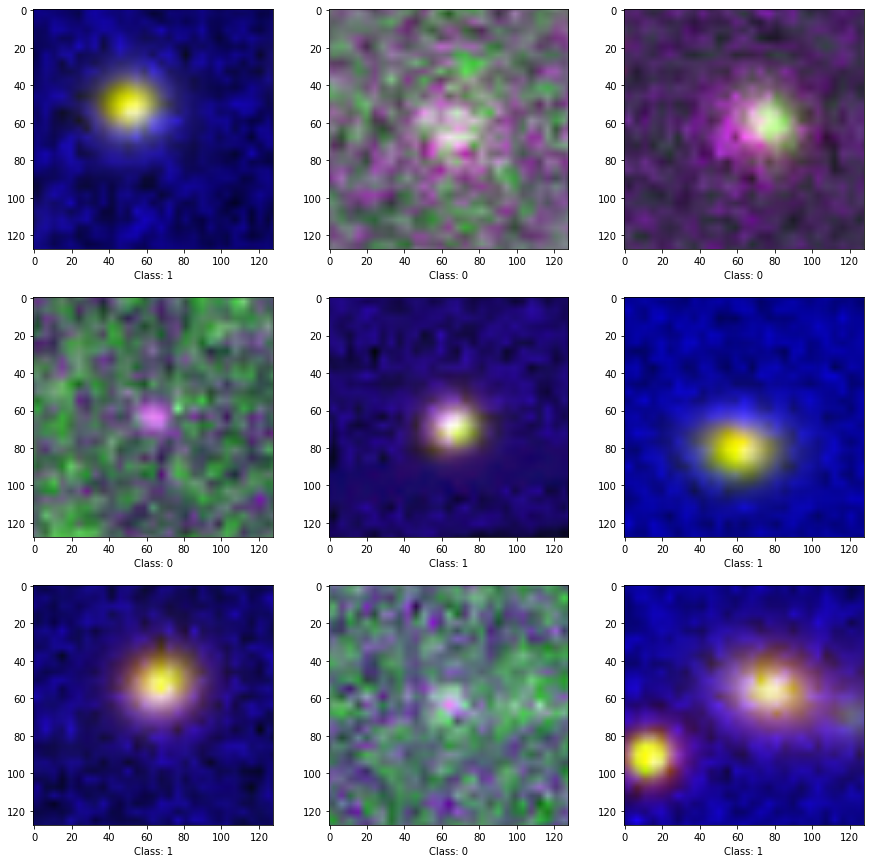

In [32]:
fig, ax = plt.subplots(3,3, figsize = (15,15))
class_dict = {'0':0,
              '1': 1
              }

for i in range (9):
  batch = next(iter(train_dl))
  image, label=batch['x'],batch['y']
  #print(label)
  ax.flat[i].imshow(image[0].permute(1,2,0))
  
  text = "Class: "+list(class_dict.keys())[int(label[0])]
  ax.flat[i].set_xlabel(text)